##### prepare data

###### df_cluster

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
#load data as DataFrame
df_ratings = pd.read_csv('data/ml-25m/ratings.csv')
#ratings
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [3]:
df_ratings['timestamp'] = df_ratings['timestamp'].apply(datetime.fromtimestamp)

df_ratings['year'] = df_ratings['timestamp'].dt.year

In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp,year
0,1,296,5.0,2006-05-17 23:34:04,2006
1,1,306,3.5,2006-05-17 20:26:57,2006
2,1,307,5.0,2006-05-17 20:27:08,2006
3,1,665,5.0,2006-05-17 23:13:40,2006
4,1,899,3.5,2006-05-17 20:21:50,2006


In [14]:
df_meanRating= df_ratings[['movieId', 'rating']].groupby(['movieId'],as_index=False).mean()
df_meanRating_no= df_ratings[['movieId', 'rating']].groupby(['movieId']).mean()

In [15]:
df_meanRating.rename(columns={'rating': 'meanRating'}, inplace=True)
df_meanRating_no.rename(columns={'rating': 'meanRating'}, inplace=True)

In [7]:
df_meanRating.head()

,movieId,meanRating
0,1,3.893708
1,2,3.251527
2,3,3.142028
3,4,2.853547
4,5,3.058434


In [17]:
df_meanRating_no.head()

,meanRating
movieId,
1,3.893708
2,3.251527
3,3.142028
4,2.853547
5,3.058434


In [18]:
df_count= df_ratings[['movieId', 'rating']].groupby(['movieId'],as_index=False).count()
df_count_no= df_ratings[['movieId', 'rating']].groupby(['movieId']).count()

In [19]:
df_count.rename(columns={'rating': 'count'}, inplace=True)
df_count_no.rename(columns={'rating': 'count'}, inplace=True)

In [20]:
df_count.head()

,movieId,count
0,1,57309
1,2,24228
2,3,11804
3,4,2523
4,5,11714


In [21]:
df_count_no.head()

,count
movieId,
1,57309
2,24228
3,11804
4,2523
5,11714


In [22]:
df_cluster= pd.concat([df_meanRating_no, df_count_no] ,axis = 1)

In [23]:
df_cluster.head()

,meanRating,count
movieId,,
1,3.893708,57309
2,3.251527,24228
3,3.142028,11804
4,2.853547,2523
5,3.058434,11714


In [24]:
df_cluster.describe()

,meanRating,count
count,59047.000000,59047.000000
mean,3.071374,423.393144
std,0.739840,2477.885821
min,0.500000,1.000000
25%,2.687500,2.000000
50%,3.150000,6.000000
75%,3.500000,36.000000
max,5.000000,81491.000000


###### df_cluster2

In [25]:
import pandas as pd

df_movies = pd.read_csv('data/ml-25m/movies.csv')

In [26]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
#we got 1639 types of genres combination
df_movies.groupby(['genres'])['genres'].nunique()

genres
(no genres listed)                     1
Action                                 1
Action|Adventure                       1
Action|Adventure|Animation             1
Action|Adventure|Animation|Children    1
                                      ..
Thriller|War                           1
Thriller|Western                       1
War                                    1
War|Western                            1
Western                                1
Name: genres, Length: 1639, dtype: int64

In [28]:
#Label encoding

from sklearn.preprocessing import LabelEncoder 
# import labelencoder
labelencoder = LabelEncoder() 
df_movies['genres'] = labelencoder.fit_transform(df_movies['genres']) 
df_movies

,movieId,title,genres
0,1,Toy Story (1995),594
1,2,Jumanji (1995),701
2,3,Grumpier Old Men (1995),1294
3,4,Waiting to Exhale (1995),1228
4,5,Father of the Bride Part II (1995),1136
...,...,...,...
62418,209157,We (2018),1424
62419,209159,Window of the Soul (2001),1398
62420,209163,Bad Poems (2018),1190
62421,209169,A Girl Thing (2001),0


In [29]:
# df_cluster2= pd.concat([df_meanRating, df_count,df_movies] ,join='inner',axis = 1)
df_cluster2=pd.merge(df_meanRating,df_count, on='movieId')
df_cluster2=pd.merge(df_cluster2,df_movies, on='movieId')

In [30]:
df_cluster2.head()

,movieId,meanRating,count,title,genres
0,1,3.893708,57309,Toy Story (1995),594
1,2,3.251527,24228,Jumanji (1995),701
2,3,3.142028,11804,Grumpier Old Men (1995),1294
3,4,2.853547,2523,Waiting to Exhale (1995),1228
4,5,3.058434,11714,Father of the Bride Part II (1995),1136


In [31]:
df_cluster2= df_cluster2.drop(['title'], axis=1)
df_cluster2.head()

,movieId,meanRating,count,genres
0,1,3.893708,57309,594
1,2,3.251527,24228,701
2,3,3.142028,11804,1294
3,4,2.853547,2523,1228
4,5,3.058434,11714,1136


##### K-means_meanRating&count

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets

In [33]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_cluster)
    distortions.append(kmeanModel.inertia_)

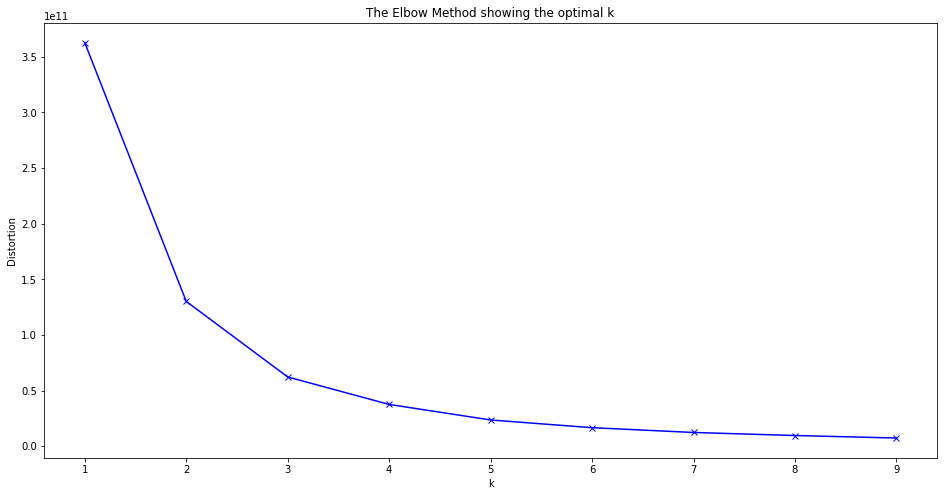

In [34]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [35]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(df_cluster)

KMeans(n_clusters=4)

In [36]:
df_cluster['k_means']=kmeanModel.predict(df_cluster)

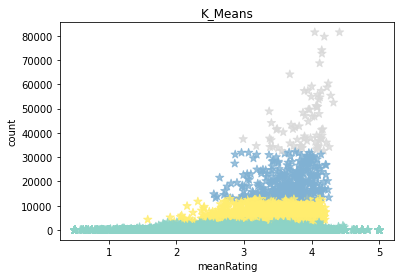

In [44]:
plt.scatter(df_cluster['meanRating'], \
                    df_cluster['count'], s= 75 ,\
                    alpha= 0.8 , c=df_cluster['k_means'], \
                    marker="*",\
                    cmap=plt.cm.Set3)
plt.title("K_Means")
plt.xlabel("meanRating")
plt.ylabel("count")
plt.show()

##### K-means_genre&meanRating&count

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets

In [39]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_cluster2)
    distortions.append(kmeanModel.inertia_)

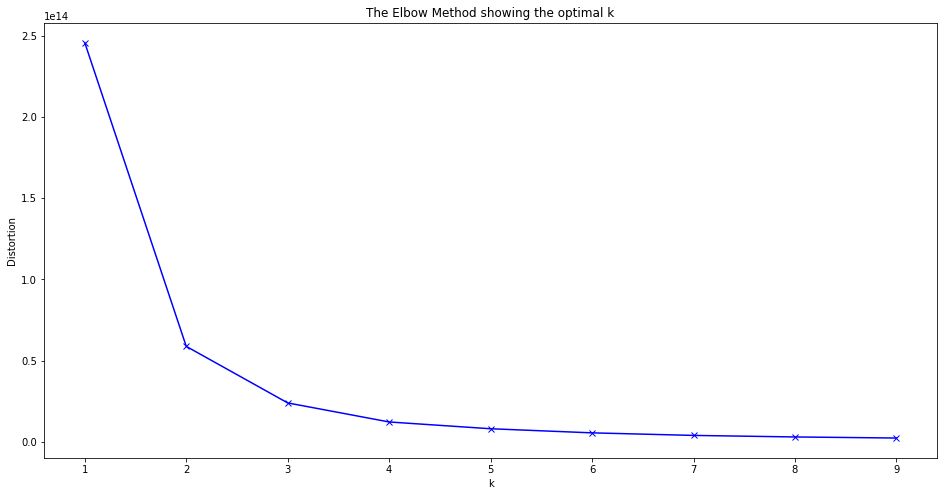

In [40]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [41]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(df_cluster2)

KMeans(n_clusters=4)

In [42]:
df_cluster2['k_means']=kmeanModel.predict(df_cluster2)

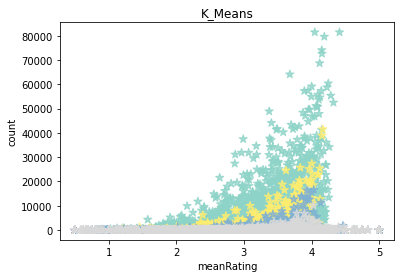

In [43]:
plt.scatter(df_cluster2['meanRating'], \
                    df_cluster2['count'], s= 75 ,\
                    alpha= 0.8 , c=df_cluster2['k_means'], \
                    marker="*",\
                    cmap=plt.cm.Set3)
plt.title("K_Means")
plt.xlabel("meanRating")
plt.ylabel("count")
plt.show()